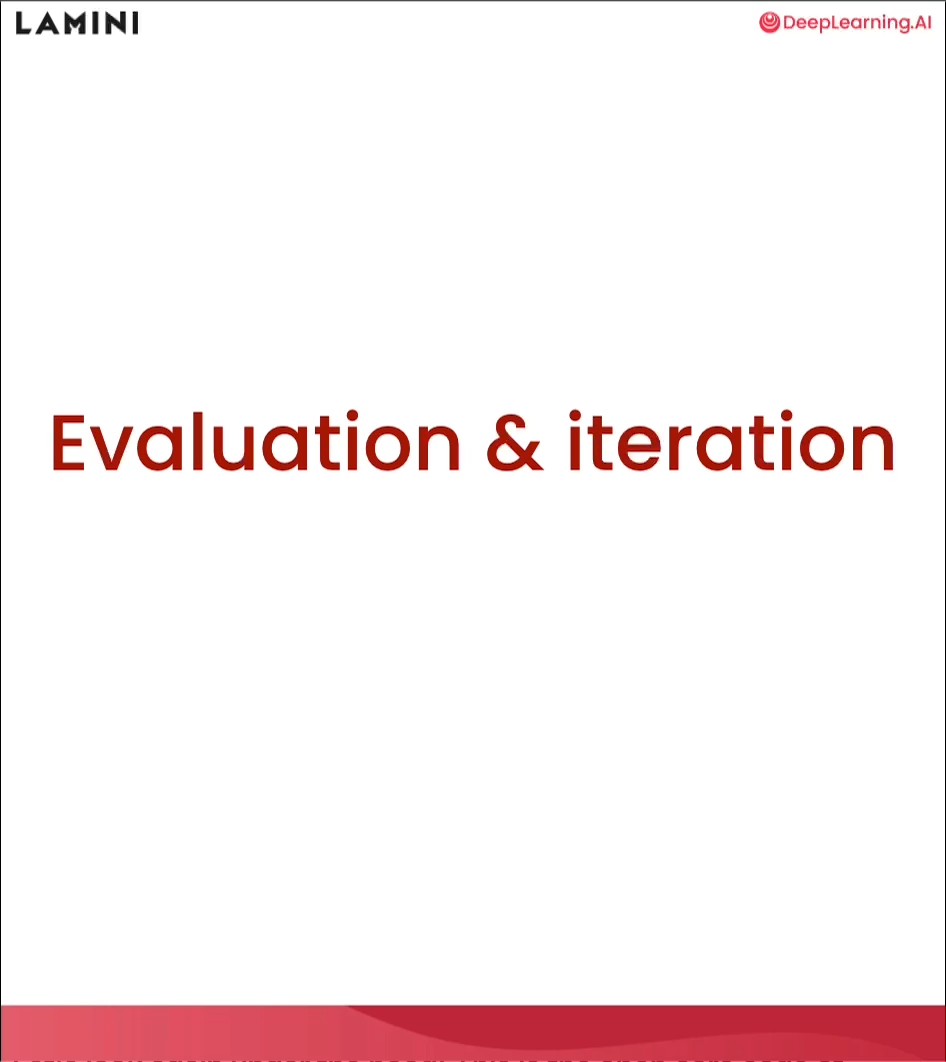

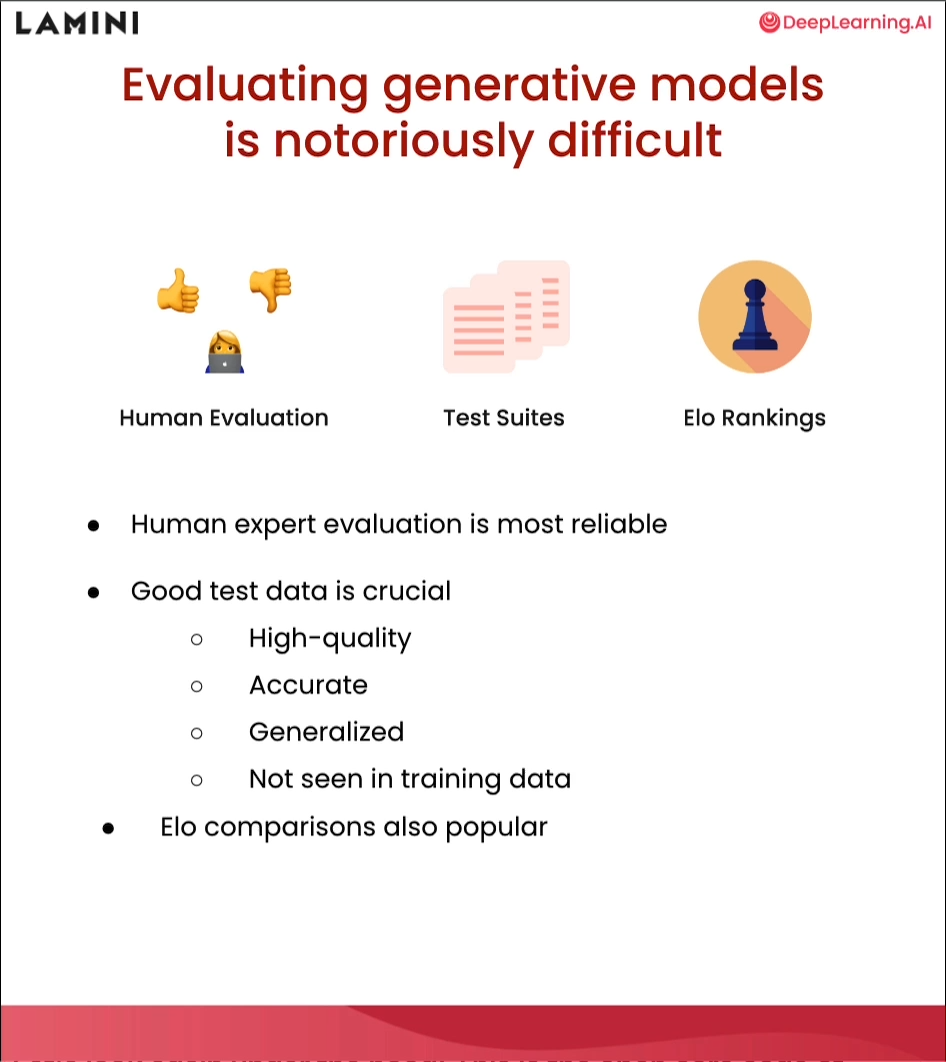

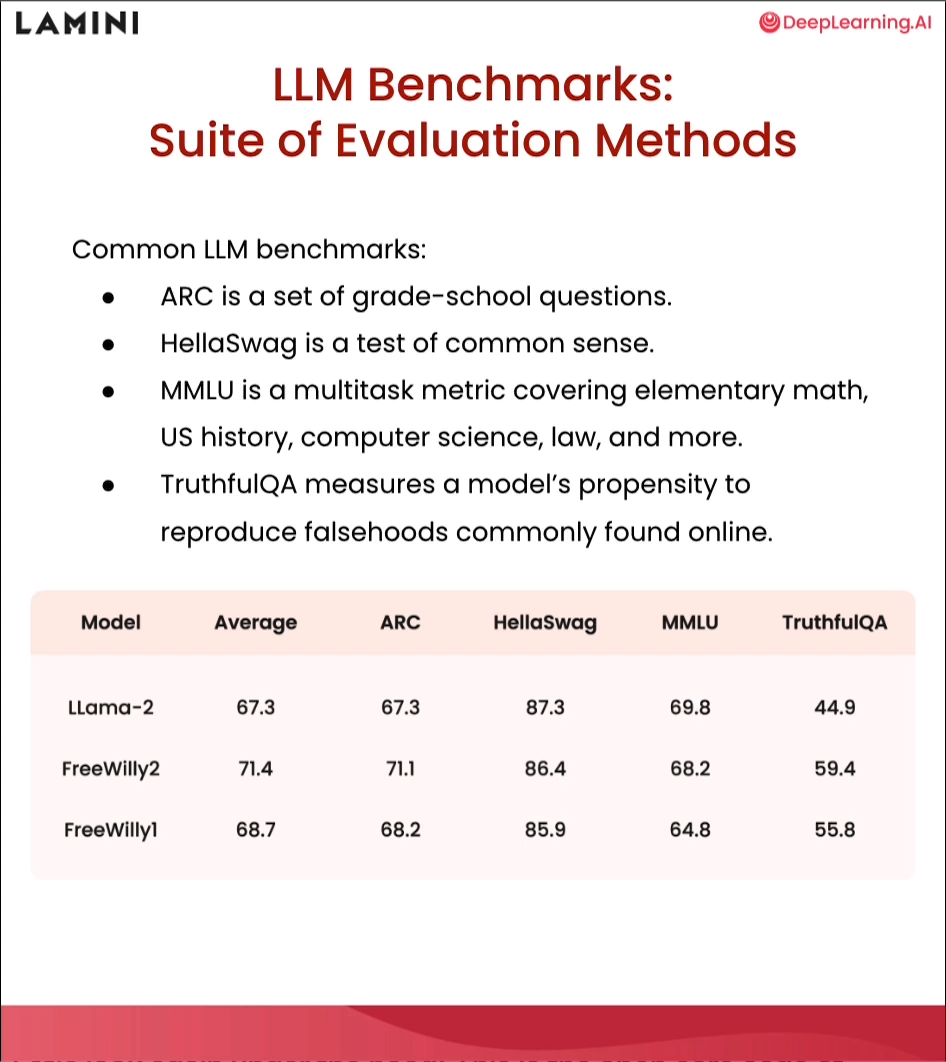

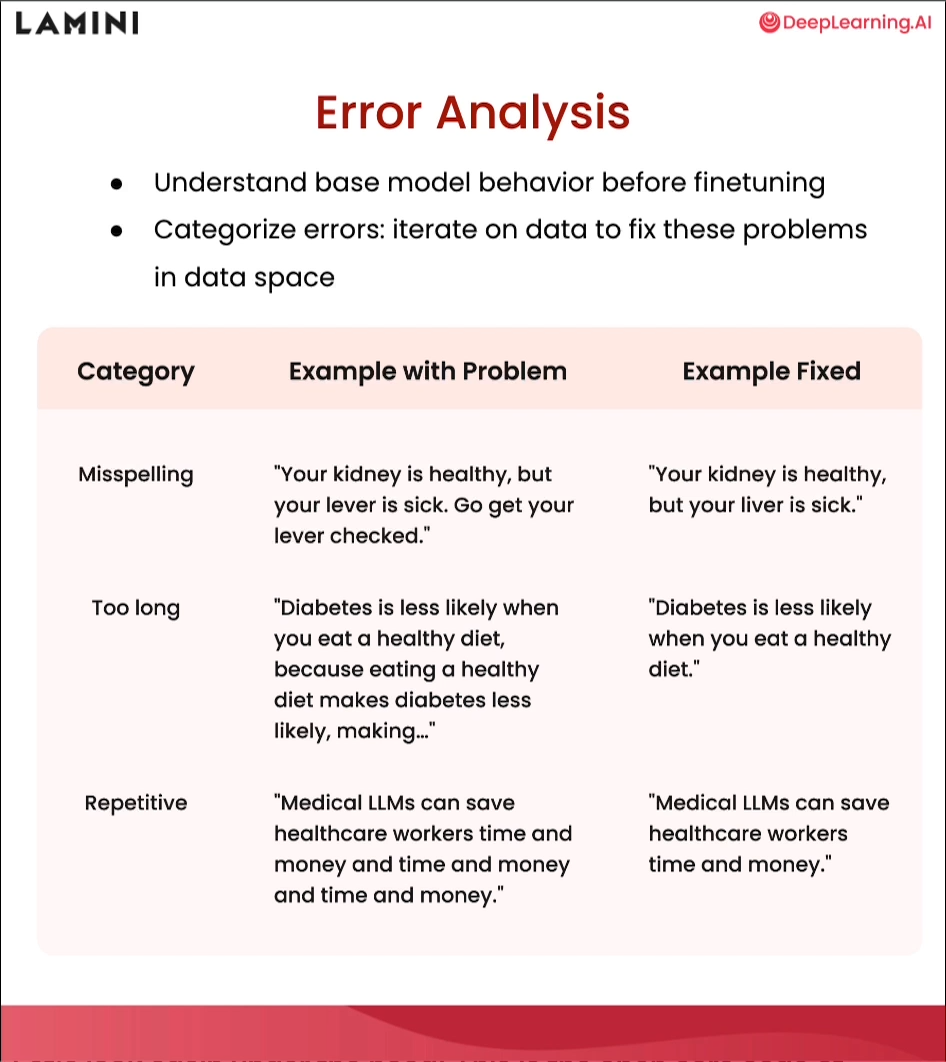

# Evaluation

### Technically, there are very few steps to run it on GPUs, elsewhere (ie. on Lamini).
```
finetuned_model = BasicModelRunner(
    "lamini/lamini_docs_finetuned"
)
finetuned_output = finetuned_model(
    test_dataset_list # batched!
) 
```

### Let's look again under the hood! This is the open core code of Lamini's `llama` library :)

In [26]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import logging
import difflib
import pandas as pd

import transformers
import datasets
import torch

from tqdm import tqdm
from utilities import *
from transformers import AutoTokenizer, AutoModelForCausalLM

logger = logging.getLogger(__name__)
global_config = None

In [27]:
dataset = datasets.load_dataset("lamini/lamini_docs")

test_dataset = dataset["test"]

In [28]:
print(test_dataset[0]["question"])
print(test_dataset[0]["answer"])

Can Lamini generate technical documentation or user manuals for software projects?
Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


In [29]:
model_name = "lamini/lamini_docs_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Setup a really basic evaluation function

In [30]:
def is_exact_match(a, b):
    return a.strip() == b.strip()

In [31]:
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [32]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  tokenizer.pad_token = tokenizer.eos_token
  input_ids = tokenizer.encode(
      text,
      return_tensors="pt",
      truncation=True,
      max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

### Run model and compare to expected answer

In [33]:
test_question = test_dataset[0]["question"]
generated_answer = inference(test_question, model, tokenizer)
print(test_question)
print(generated_answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Can Lamini generate technical documentation or user manuals for software projects?
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


In [34]:
answer = test_dataset[0]["answer"]
print(answer)

Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


In [35]:
exact_match = is_exact_match(generated_answer, answer)
print(exact_match)

False


### Run over entire dataset

In [36]:
n = 10
metrics = {'exact_matches': []}
predictions = []
for i, item in tqdm(enumerate(test_dataset)):
    print("i Evaluating: " + str(item))
    question = item['question']
    answer = item['answer']

    try:
      predicted_answer = inference(question, model, tokenizer)
    except:
      continue
    predictions.append([predicted_answer, answer])

    #fixed: exact_match = is_exact_match(generated_answer, answer)
    exact_match = is_exact_match(predicted_answer, answer)
    metrics['exact_matches'].append(exact_match)

    if i > n and n != -1:
      break
print('Number of exact matches: ', sum(metrics['exact_matches']))

0it [00:00, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Can Lamini generate technical documentation or user manuals for software projects?', 'answer': 'Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.', 'input_ids': [5804, 418, 4988, 74, 6635, 7681, 10097, 390, 2608, 11595, 84, 323, 3694, 6493, 32, 4374, 13, 418, 4988, 74, 476, 6635, 7681, 10097, 285, 2608, 11595, 84, 323, 3694, 6493, 15, 733, 4648, 3626, 3448, 5978, 5609, 281, 2794, 2590, 285, 44003, 10097, 326, 310, 3477, 281, 2096, 323, 1097, 7681, 285, 1327, 14, 48746, 4212, 15, 831, 476, 5321, 12259, 247, 1534, 2408, 273, 673, 285, 3434, 275, 6153, 10097, 13, 6941, 731, 281, 2770, 327, 643, 7794, 273, 616, 6493, 1

1it [00:00,  1.66it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'How do I include my API key in the Authorization HTTP header?', 'answer': 'The Authorization HTTP header should include the API key in the following format: Authorization: Bearer <YOUR-KEY-HERE>.', 'input_ids': [2347, 513, 309, 2486, 619, 8990, 2234, 275, 253, 10360, 1320, 17607, 10478, 32, 510, 10360, 1320, 17607, 10478, 943, 2486, 253, 8990, 2234, 275, 253, 1563, 5981, 27, 10360, 1320, 27, 2325, 12287, 654, 58, 11862, 14, 13888, 14, 41, 8147, 13208], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [2347, 513, 309, 2486, 619, 8990, 2234, 275, 253, 10360, 1320, 17607, 10478, 32, 510, 10360, 1320, 17607, 10478, 943, 2486, 253, 8990, 2234, 275, 253, 1563, 5981, 27, 10360, 1320, 27, 2325, 12287, 654, 58, 11862, 14, 13888, 14, 41, 8147, 13208]}


2it [00:01,  1.68it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': "Is there a section explaining the code's approach to handling versioning and compatibility?", 'answer': 'Yes, the code includes a version parameter in the FeedbackOperation class constructor, which allows for handling versioning and compatibility.', 'input_ids': [2513, 627, 247, 2593, 15571, 253, 2127, 434, 2746, 281, 10885, 2715, 272, 285, 22862, 32, 4374, 13, 253, 2127, 3797, 247, 2715, 4764, 275, 253, 34600, 2135, 17547, 966, 16757, 13, 534, 4483, 323, 10885, 2715, 272, 285, 22862, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [2513, 627, 247, 2593, 15571, 253, 2127, 434, 2746, 281, 10885, 2715, 272, 285, 22862, 32, 4374, 13, 253, 2127, 3797, 247, 2715, 4764, 275, 253, 34600, 2135, 17547, 966, 16757, 13, 534, 4483, 323, 10885, 2715, 272, 285, 22862, 15]}


3it [00:01,  1.67it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Is there a community or support forum available for Lamini users?', 'answer': 'Yes, there is a community forum available for Lamini users. The Lamini community forum can be accessed through the Lamini website and provides a platform for users to ask questions, share ideas, and collaborate with other developers using the library. Additionally, the Lamini team is active on the forum and provides support and guidance to users as needed.', 'input_ids': [2513, 627, 247, 3114, 390, 1329, 12209, 2130, 323, 418, 4988, 74, 4212, 32, 4374, 13, 627, 310, 247, 3114, 12209, 2130, 323, 418, 4988, 74, 4212, 15, 380, 418, 4988, 74, 3114, 12209, 476, 320, 19197, 949, 253, 418, 4988, 74, 4422, 285, 3400, 247, 5147, 323, 4212, 281, 1642, 3533, 13, 3894, 5697, 13, 285, 42124, 342, 643, 12259, 970, 253, 6335, 15, 9157, 13, 253, 418, 4988, 74, 2285, 310, 3939, 327, 253, 12209, 285, 3400, 1329, 285, 12925, 281, 4212, 347, 3058, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

4it [00:02,  1.68it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Can the Lamini library be utilized for text completion or auto-completion tasks, such as filling in missing words or predicting the next word in a sentence?', 'answer': 'The Lamini library is not specifically designed for text completion or auto-completion tasks. However, it can be used for language modeling and generating text based on a given prompt.', 'input_ids': [5804, 253, 418, 4988, 74, 6335, 320, 12845, 323, 2505, 12240, 390, 6753, 14, 45634, 8892, 13, 824, 347, 12868, 275, 5816, 3000, 390, 21565, 253, 1735, 3159, 275, 247, 6197, 32, 510, 418, 4988, 74, 6335, 310, 417, 5742, 4158, 323, 2505, 12240, 390, 6753, 14, 45634, 8892, 15, 1723, 13, 352, 476, 320, 908, 323, 3448, 14053, 285, 11365, 2505, 1754, 327, 247, 1677, 8959, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'la

5it [00:02,  1.80it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Are there any costs associated with using Lamini for machine learning tasks, and how does the pricing structure work?', 'answer': 'Lamini offers both free and paid plans for using their machine learning services. The free plan includes limited access to their models and data generator, while the paid plans offer more advanced features and higher usage limits. The pricing structure is based on a pay-as-you-go model, where users are charged based on the number of API requests and data processed. Lamini also offers custom enterprise plans for larger organizations with specific needs.', 'input_ids': [6723, 627, 667, 4815, 2330, 342, 970, 418, 4988, 74, 323, 5145, 4715, 8892, 13, 285, 849, 1057, 253, 20910, 2605, 789, 32, 45, 4988, 74, 6131, 1097, 1959, 285, 5087, 5827, 323, 970, 616, 5145, 4715, 3238, 15, 380, 1959, 2098, 3797, 3710, 2289, 281, 616, 3210, 285, 941, 14156, 13, 1223, 253, 5087, 5827, 3959, 625, 7269, 3386, 285, 2169, 10393, 7787, 15, 380, 20910, 2

6it [00:03,  1.83it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'How do I instantiate the LLM engine using the Lamini Python package?', 'answer': 'You can instantiate the LLM engine using the llama module in the Lamini Python package. To do this, you need to import the LLM engine from the llama module, like this: from llama import LLM.', 'input_ids': [2347, 513, 309, 8164, 4513, 253, 21708, 46, 3948, 970, 253, 418, 4988, 74, 13814, 5522, 32, 1394, 476, 8164, 4513, 253, 21708, 46, 3948, 970, 253, 26198, 2902, 6333, 275, 253, 418, 4988, 74, 13814, 5522, 15, 1916, 513, 436, 13, 368, 878, 281, 1395, 253, 21708, 46, 3948, 432, 253, 26198, 2902, 6333, 13, 751, 436, 27, 432, 26198, 2902, 1395, 21708, 46, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [2347, 513, 309, 8164, 4513, 253, 21708, 46, 3948, 970, 253, 418, 4988, 74, 13814, 5522, 32, 1394

7it [00:03,  1.79it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Does Lamini provide any mechanisms for model compression or optimization to reduce memory footprint?', 'answer': 'Yes, Lamini provides mechanisms for model compression and optimization to reduce memory footprint. These include techniques such as pruning, quantization, and distillation, which can significantly reduce the size of the model while maintaining its performance. Additionally, Lamini offers support for deploying customized LLMs on edge devices with limited resources, such as mobile phones or IoT devices, through techniques such as model quantization and on-device inference.', 'input_ids': [10795, 418, 4988, 74, 2085, 667, 6297, 323, 1566, 13800, 390, 13757, 281, 4796, 3541, 33257, 32, 4374, 13, 418, 4988, 74, 3400, 6297, 323, 1566, 13800, 285, 13757, 281, 4796, 3541, 33257, 15, 2053, 2486, 5609, 824, 347, 819, 25004, 13, 36643, 13, 285, 940, 21755, 13, 534, 476, 3012, 4796, 253, 1979, 273, 253, 1566, 1223, 11850, 697, 3045, 15, 9157, 13, 418, 4988, 

8it [00:04,  1.72it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'How does the performance of LLMs trained using Lamini compare to models fine-tuned with traditional approaches?', 'answer': 'According to the information provided, Lamini allows developers to train high-performing LLMs on large datasets with just a few lines of code from the Lamini library. The optimizations in this library reach far beyond what’s available to developers now, from more challenging optimizations like RLHF to simpler ones like reducing hallucinations. While there is no direct comparison to traditional approaches mentioned, Lamini aims to make training LLMs faster and more accessible to a wider range of developers.', 'input_ids': [2347, 1057, 253, 3045, 273, 21708, 12822, 10166, 970, 418, 4988, 74, 7277, 281, 3210, 4030, 14, 85, 37437, 342, 5899, 7274, 32, 7130, 281, 253, 1491, 2530, 13, 418, 4988, 74, 4483, 12259, 281, 6194, 1029, 14, 468, 14692, 21708, 12822, 327, 1781, 15302, 342, 816, 247, 1643, 3104, 273, 2127, 432, 253, 418, 4988, 74, 633

9it [00:05,  1.74it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Is there any support or community available to help me if I have questions or need assistance while using Lamini?', 'answer': 'Yes, there is a support community available to assist you with any questions or issues you may have while using Lamini. You can join the Lamini Discord server or reach out to the Lamini team directly for assistance.', 'input_ids': [2513, 627, 667, 1329, 390, 3114, 2130, 281, 1361, 479, 604, 309, 452, 3533, 390, 878, 8385, 1223, 970, 418, 4988, 74, 32, 4374, 13, 627, 310, 247, 1329, 3114, 2130, 281, 10073, 368, 342, 667, 3533, 390, 3374, 368, 778, 452, 1223, 970, 418, 4988, 74, 15, 1422, 476, 6604, 253, 418, 4988, 74, 15292, 636, 4771, 390, 3986, 562, 281, 253, 418, 4988, 74, 2285, 3587, 323, 8385, 15], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'l

10it [00:05,  1.77it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Are there any code samples illustrating how to implement custom logging handlers?', 'answer': 'Yes, the Python logging module documentation provides several examples of how to implement custom logging handlers. You can find them in the official documentation here: https://docs.python.org/3/howto/logging-cookbook.html#developing-new-handlers', 'input_ids': [6723, 627, 667, 2127, 3530, 34805, 849, 281, 3359, 2840, 20893, 40093, 32, 4374, 13, 253, 13814, 20893, 6333, 10097, 3400, 2067, 6667, 273, 849, 281, 3359, 2840, 20893, 40093, 15, 1422, 476, 1089, 731, 275, 253, 3565, 10097, 1060, 27, 5987, 1358, 13880, 15, 16659, 15, 2061, 16, 20, 16, 5430, 936, 16, 36193, 14, 29519, 3305, 15, 2974, 4, 16714, 272, 14, 1826, 14, 4608, 10787], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 

11it [00:06,  1.71it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


i Evaluating: {'question': 'Are there any code samples illustrating how to handle authentication and authorization?', 'answer': 'Yes, there is a separate section in the documentation explaining authentication, for more information visit https://lamini-ai.github.io/auth/', 'input_ids': [6723, 627, 667, 2127, 3530, 34805, 849, 281, 6016, 19676, 285, 26239, 32, 4374, 13, 627, 310, 247, 4858, 2593, 275, 253, 10097, 15571, 19676, 13, 323, 625, 1491, 4143, 5987, 1358, 77, 4988, 74, 14, 2284, 15, 7280, 15, 900, 16, 14399, 16], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [6723, 627, 667, 2127, 3530, 34805, 849, 281, 6016, 19676, 285, 26239, 32, 4374, 13, 627, 310, 247, 4858, 2593, 275, 253, 10097, 15571, 19676, 13, 323, 625, 1491, 4143, 5987, 1358, 77, 4988, 74, 14, 2284, 15, 7280, 15, 900, 16, 14399, 16]}



11it [00:06,  1.58it/s]

Number of exact matches:  0


In [37]:
df = pd.DataFrame(predictions, columns=["predicted_answer", "target_answer"])
print(df)

                                     predicted_answer  \
0   Yes, Lamini can generate technical documentati...   
1   You can use the Authorization HTTP header to g...   
2   Lamini’s LLM Engine is a LLM Engine for develo...   
3   Yes, there is a community or support forum ava...   
4   Yes, the Lamini library can be utilized for te...   
5   Lamini is designed to be flexible and scalable...   
6   You can instantiate the LLM engine using the L...   
7   Yes, Lamini provides mechanisms for compressio...   
8   The performance of LLMs trained using Lamini c...   
9   Yes, there is a support and community availabl...   
10  Yes, there are some code samples available in ...   
11  Yes, there are some code samples available tha...   

                                        target_answer  
0   Yes, Lamini can generate technical documentati...  
1   The Authorization HTTP header should include t...  
2   Yes, the code includes a version parameter in ...  
3   Yes, there is a community foru

### Evaluate all the data

In [38]:
evaluation_dataset_path = "lamini/lamini_docs_evaluation"
evaluation_dataset = datasets.load_dataset(evaluation_dataset_path)

In [39]:
pd.DataFrame(evaluation_dataset)

,train
0,"{'predicted_answer': 'Yes, Lamini can generate..."
1,{'predicted_answer': 'You can use the Authoriz...
2,{'predicted_answer': 'Lamini’s LLM Engine is a...
3,"{'predicted_answer': 'Yes, there is a communit..."
4,"{'predicted_answer': 'Yes, the Lamini library ..."
...,...
134,"{'predicted_answer': 'Yes, Lamini has the abil..."
135,{'predicted_answer': 'I wish! This documentati...
136,"{'predicted_answer': 'Yes, Lamini can generate..."
137,"{'predicted_answer': 'Yes, the documentation h..."


### Try the ARC benchmark
This can take several minutes

In [40]:
!python lm-evaluation-harness/main.py --model hf-causal --model_args pretrained=lamini/lamini_docs_finetuned --tasks arc_easy --device cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Selected Tasks: ['arc_easy']
Using device 'cpu'
/usr/local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Task: arc_easy; number of docs: 2376
Task: arc_easy; document 0; context prompt (starting on next line):
Question: Which is the function of the gallbladder?
Answer:
(end of prompt on previous line)
Requests: [Req_loglikelihood('Question: Which is the function of the gallbladder?\nAnswer:', ' store bile')[0]
, Req_loglikelihood('Question: Which